# 3. MORDM
## 3.1 Installing EMA workbench and importing libraries
This section installs the necessary libraries such as numpy and pandas. It also imports the EMA workbench and initializes it using problem formulation 2

In [6]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    Scenario
)
import numpy as np
import pandas as pd
import copy
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

levers = copy.deepcopy(dike_model.levers)

for outcome in dike_model.outcomes:
    print(repr(outcome))



ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x000002E59A99A480>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x000002E59A99A480>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x000002E59A99A480>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x000002E59A99A480>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

## 3.2 Searching for candidate solutions
In this step, candidate strategies are identified which are pareto optimal: conditional on a reference scenario.  

Taking model interface developed in the previous step and using the optimization functionality of the workbench to identify the pareto approximate set of solutions.  
Only statistically significant adaptions are applied (A.1_pfail)

In [7]:
reference_scenario = Scenario('reference', **{'discount rate 0': 2.5, 'discount rate 1': 2.5,
                                              'discount rate 2': 2.5, 'A.0_ID flood wave shape': 75,
                                              'A.1_Bmax': 190, 'A.1_pfail': (0.903212 - 0.000009)/2,
                                                                                 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 190, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 190, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 190, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 190, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})


Starting values: epsilon = .1 and nfe = 5000 to enable an accuracy and convergence and considering computational power:

In [8]:
from ema_workbench.em_framework.optimization import EpsilonProgress

convergence_metrics = [EpsilonProgress()]
nfe = 50000
epsilon = [0.1,] * len(dike_model.outcomes)

In [9]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    total = evaluator.optimize(
                nfe=nfe,
                searchover='levers',
                epsilons=epsilon,
                convergence=convergence_metrics,
                reference=reference_scenario)

[MainProcess/INFO] pool started with 4 workers
51089it [7:02:50,  2.01it/s]                                                   
[MainProcess/INFO] optimization completed, found 349 solutions
[MainProcess/INFO] terminating pool


Setting the goal according to data found during the policy excercise:
- For the highest shipping boat class, a water level higher than 4 is needed. This means solutions where min water level > 4 are sought
-All solutions satisfy this criteria.

In [10]:
archive, convergence = total

archive.to_excel('archive_MORDM_2.xlsx')
convergence.to_excel('convergence_MORDM_2.xlsx')

#archive[archive['Min Water Level']>4.807055]

policies_pareto = archive[archive['Expected Annual Damage']==0]


policies_pareto

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Min Water Level,Max Water Level
48,0,0,0,0,0,0,0,1,0,0,...,4,0,0,0.0,1.636335e+08,3.070000e+07,0.0,0.0,4.5387,8.228107
68,0,1,0,0,0,0,0,1,1,0,...,3,0,0,0.0,1.100572e+08,2.672000e+08,0.0,0.0,4.4187,8.038107
79,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0.0,2.316615e+08,0.000000e+00,0.0,0.0,4.5387,8.228107
84,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0.0,8.176886e+07,8.989000e+08,0.0,0.0,4.1787,8.058107
85,0,0,0,0,0,0,1,0,1,0,...,3,0,0,0.0,1.469795e+08,5.599000e+08,0.0,0.0,4.2987,8.228107
97,1,0,0,0,0,0,1,1,1,1,...,3,0,0,0.0,9.087112e+07,5.540000e+08,0.0,0.0,4.4187,8.038107
129,0,0,0,0,0,0,1,0,1,0,...,4,0,0,0.0,1.587781e+08,6.140000e+07,0.0,0.0,4.5387,8.228107
144,0,0,0,0,0,1,1,1,1,1,...,3,0,0,0.0,8.268888e+07,6.735000e+08,0.0,0.0,4.1787,8.058107
196,0,0,0,1,0,0,1,1,1,0,...,4,0,0,0.0,1.100888e+08,3.099000e+08,0.0,0.0,4.5387,8.058107
206,1,0,0,0,0,0,1,1,1,0,...,4,0,0,0.0,9.548147e+07,2.979000e+08,0.0,0.0,4.4187,8.038107


Policies within the pareto space are identified:

In [11]:
len(policies_pareto)

17

In [12]:
policies_pareto

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Min Water Level,Max Water Level
48,0,0,0,0,0,0,0,1,0,0,...,4,0,0,0.0,1.636335e+08,3.070000e+07,0.0,0.0,4.5387,8.228107
68,0,1,0,0,0,0,0,1,1,0,...,3,0,0,0.0,1.100572e+08,2.672000e+08,0.0,0.0,4.4187,8.038107
79,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0.0,2.316615e+08,0.000000e+00,0.0,0.0,4.5387,8.228107
84,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0.0,8.176886e+07,8.989000e+08,0.0,0.0,4.1787,8.058107
85,0,0,0,0,0,0,1,0,1,0,...,3,0,0,0.0,1.469795e+08,5.599000e+08,0.0,0.0,4.2987,8.228107
97,1,0,0,0,0,0,1,1,1,1,...,3,0,0,0.0,9.087112e+07,5.540000e+08,0.0,0.0,4.4187,8.038107
129,0,0,0,0,0,0,1,0,1,0,...,4,0,0,0.0,1.587781e+08,6.140000e+07,0.0,0.0,4.5387,8.228107
144,0,0,0,0,0,1,1,1,1,1,...,3,0,0,0.0,8.268888e+07,6.735000e+08,0.0,0.0,4.1787,8.058107
196,0,0,0,1,0,0,1,1,1,0,...,4,0,0,0.0,1.100888e+08,3.099000e+08,0.0,0.0,4.5387,8.058107
206,1,0,0,0,0,0,1,1,1,0,...,4,0,0,0.0,9.548147e+07,2.979000e+08,0.0,0.0,4.4187,8.038107



The convergence of the selected epsilon and nfe values is analyzed: 

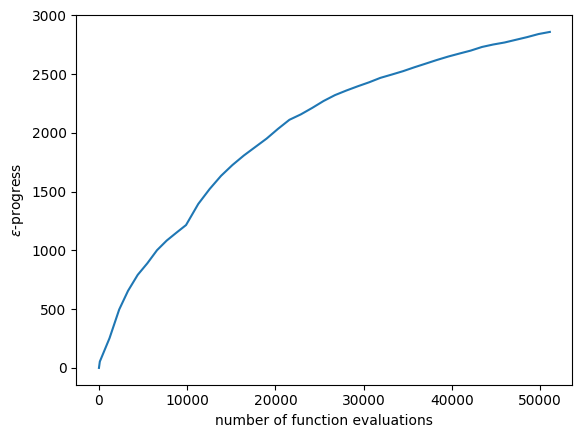

In [13]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

Convergence is not reached, however due to computational power limitations, this is deemed acceptable

## 3.3 Evaluating policies under uncertainty 
This section evaluates the identified policies under uncertainty. The worst case values are calculated taking into account 1,000 scenarios 

In [35]:

from ema_workbench import Policy

policies_pareto.index = [i for i in range(len(policies_pareto.index))]

policies_pareto = policies_pareto.drop([o.name for o in dike_model.outcomes], axis=1)

policies_to_evaluate = []

for i, policy in policies_pareto.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

#policies_to_evaluate

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 3, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 3, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 7, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 4, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 3, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 7, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre

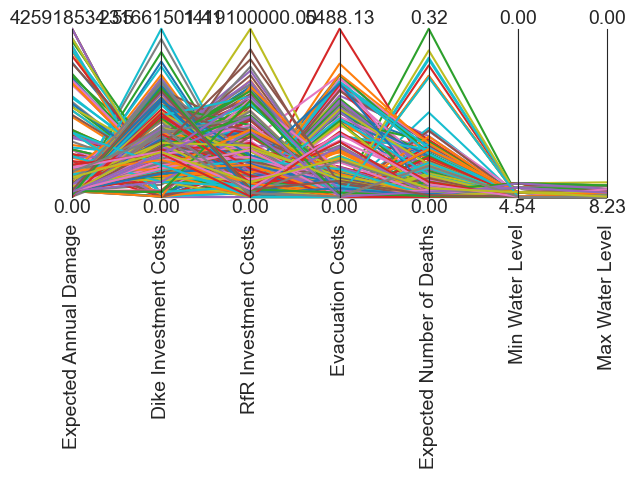

In [22]:
from ema_workbench.analysis import parcoords


data = archive.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Min Water Level')
paraxes.invert_axis('Max Water Level')
plt.show()

Interpretation:
Solutions with max water level are strongly correlated with min water level and with min EAD

A constraint is set to evaluate policies with an Expected Annual Damage of 0, as this is deemed to be the variable of interest:

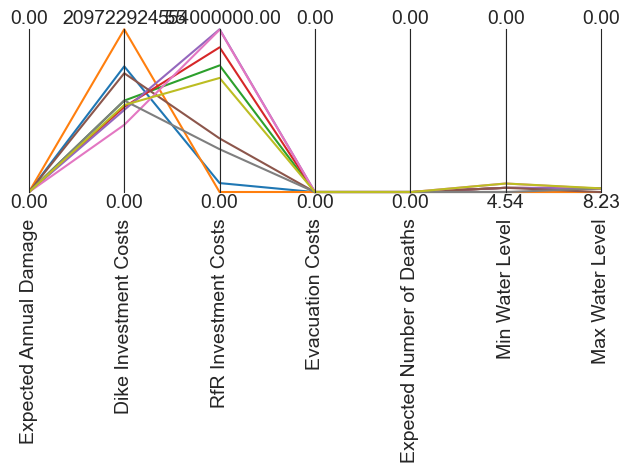

In [41]:
archive_filter = archive[archive['Expected Annual Damage']==0]

data = archive_filter.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Min Water Level')
paraxes.invert_axis('Max Water Level')
plt.show()

Interpretation: It can be observed that the low EAD, END and high min water level are related with high RfR investment costs or high dike investment costs. The latter are on average higher.

Next, a statistical analysis is developed:

<Axes: >

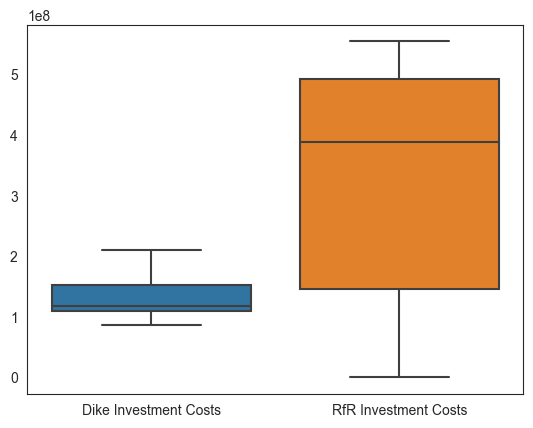

In [45]:
import seaborn as sns

sns.boxplot(archive_filter[[o.name for o in dike_model.outcomes]].iloc[:,1:3])


Interpretation: This figure shows that the spread in RfR investment costs is larger than Dike investment costs. This is useful information towards final policy recommendations 

In [46]:
policies_to_evaluate

[Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 3, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 3, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 7, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 4, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 3, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 7, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncre



With the set of optimal policies for the given seed, the evaluation for worst case scenarios is started using 1,000 scenarios. 
The objective is to find scenarios with performances below the following thresholds:
1. water level min <4
2. EAD > EAD BAU case 
3. EAD extreme

In [47]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

experiments, outcomes = results

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 9 policies * 1 model(s) = 9000 experiments
100%|██████████████████████████████████████| 9000/9000 [30:08<00:00,  4.98it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


The outcomes are visualized to gain a better understanding 

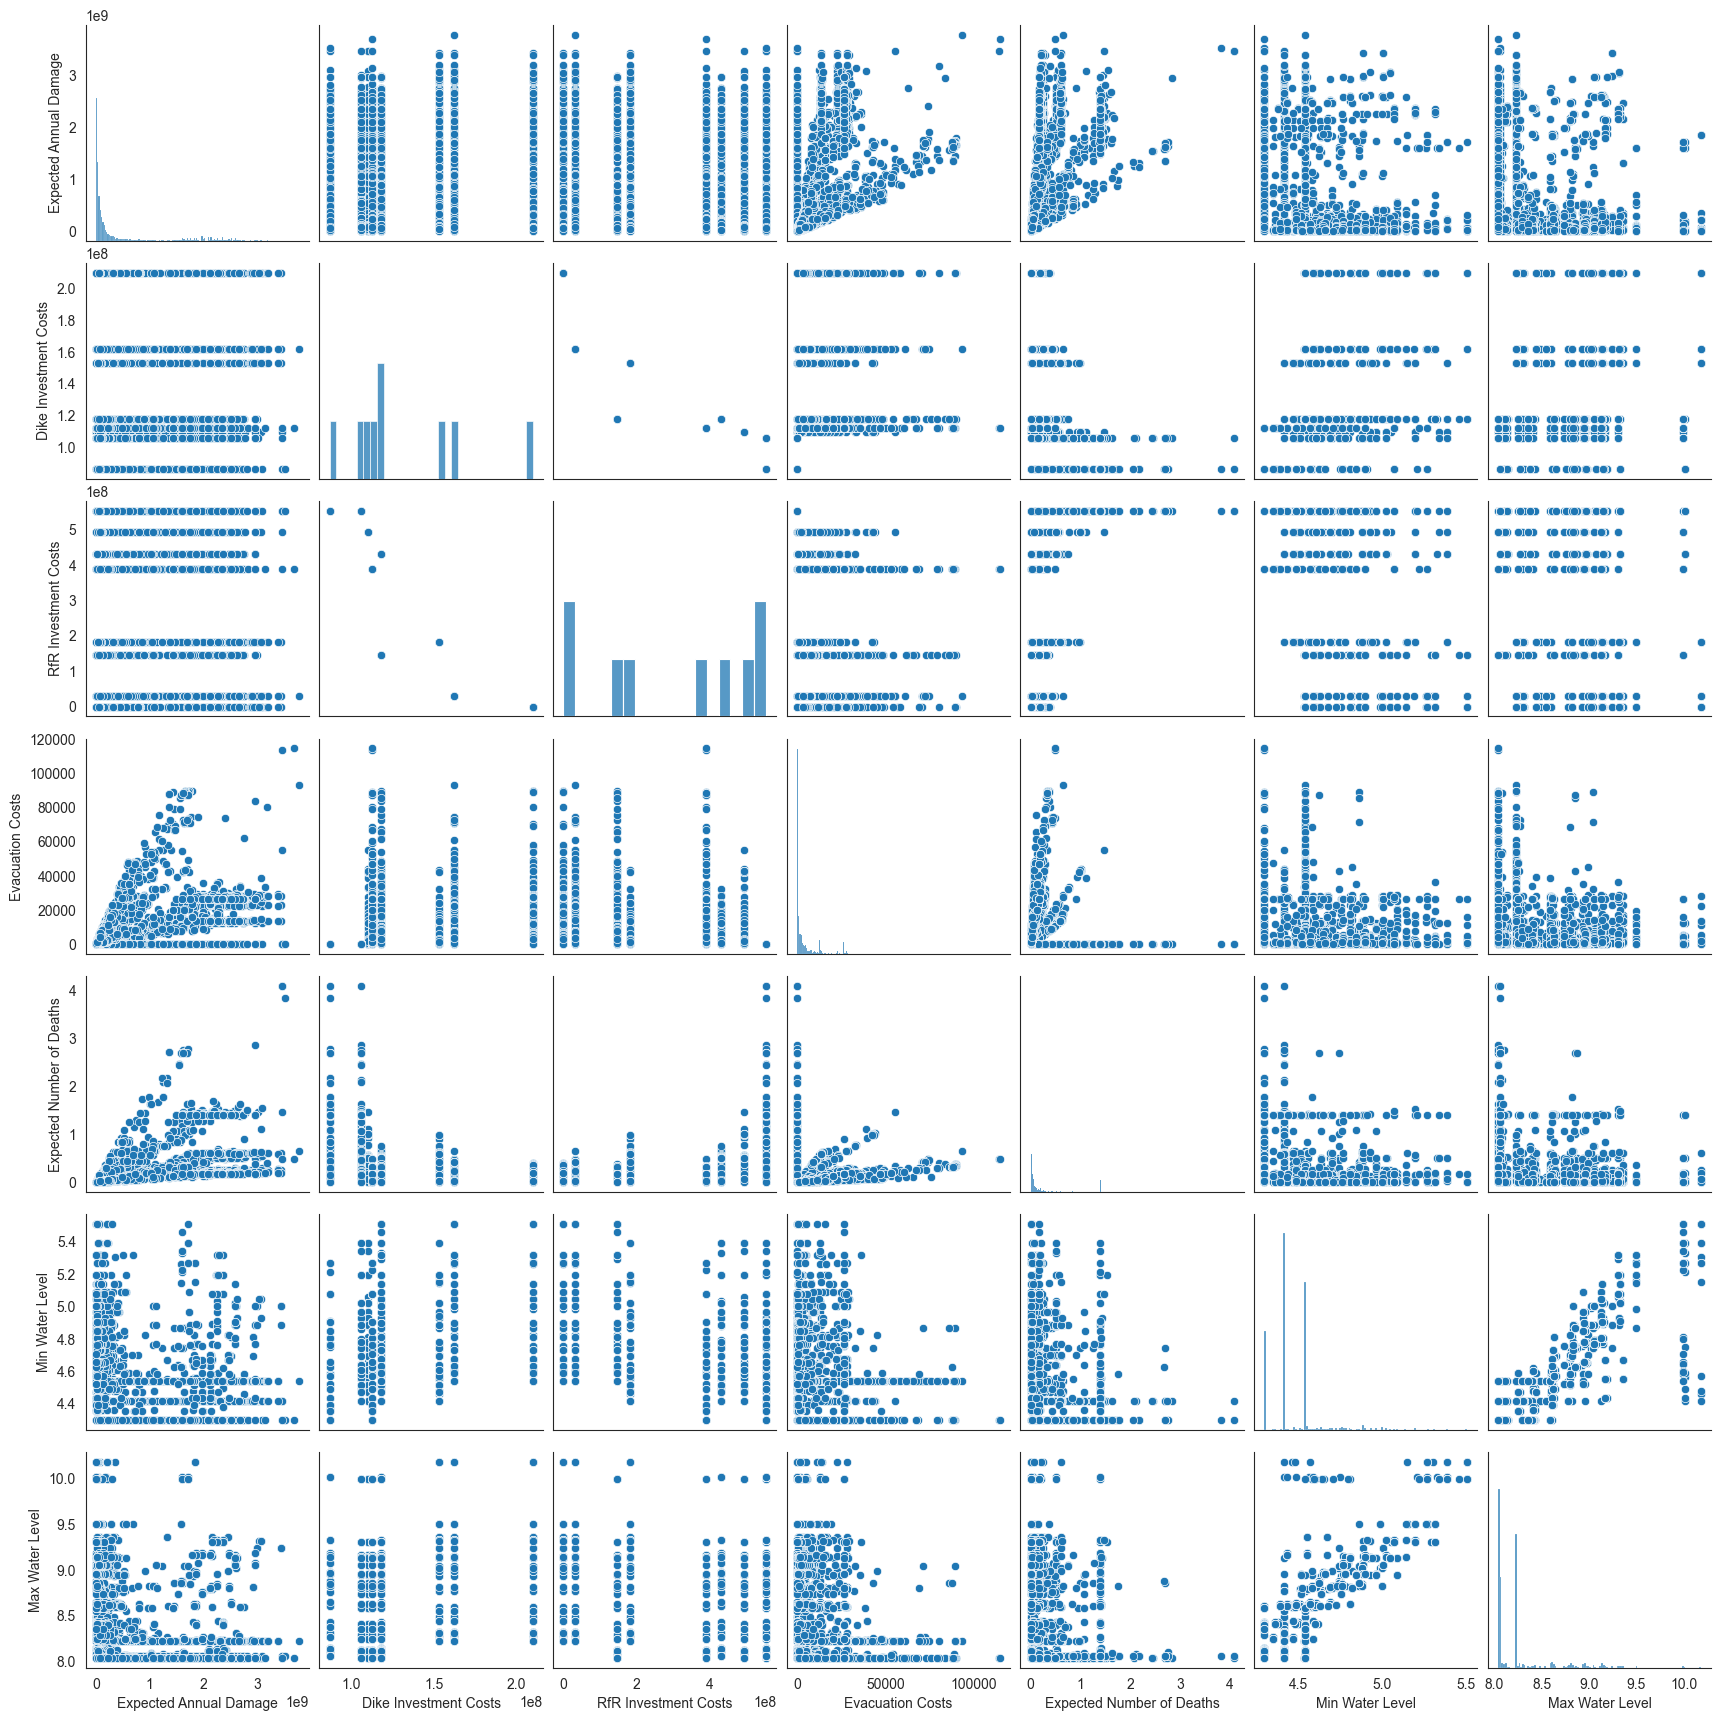

In [48]:
sns.pairplot(pd.DataFrame(outcomes))


<Axes: >

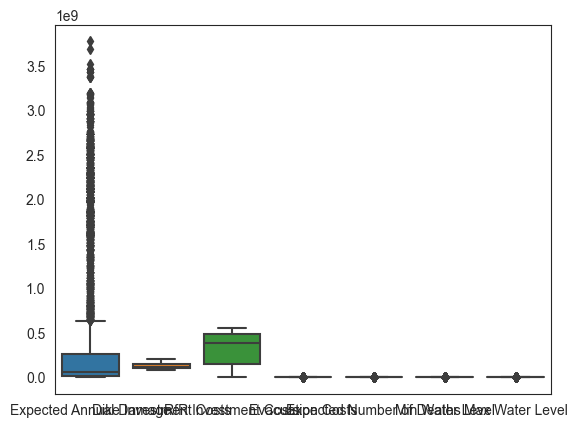

In [50]:
sns.boxplot(pd.DataFrame(outcomes))

Interpretation: While the selected policies have a general acceptable distribution within the Expected Annual Damage values, there are very high outliers

In [66]:
pd.DataFrame(outcomes).describe([.75,.9,.95,.99])

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Min Water Level,Max Water Level
count,9.000000e+03,9.000000e+03,9.000000e+03,9000.000000,9000.000000,9000.000000,9000.000000
mean,4.123143e+08,1.305578e+08,3.086333e+08,5094.576069,0.133972,4.481468,8.245162
std,7.454093e+08,3.558566e+07,2.080763e+08,9992.538539,0.319396,0.171718,0.344192
min,0.000000e+00,8.664763e+07,0.000000e+00,0.000000,0.000000,4.298164,8.038100
50%,6.706972e+07,1.178368e+08,3.884000e+08,1090.705695,0.018634,4.418700,8.058660
75%,2.674766e+08,1.531372e+08,4.926000e+08,4781.590361,0.092845,4.538700,8.228318
90%,1.864281e+09,2.097229e+08,5.540000e+08,14739.006317,0.399619,4.633102,8.796880
95%,2.252112e+09,2.097229e+08,5.540000e+08,26385.120798,0.612725,4.865888,9.072885
99%,2.738535e+09,2.097229e+08,5.540000e+08,44268.985961,1.405621,5.190152,9.355268
max,3.771966e+09,2.097229e+08,5.540000e+08,114556.809397,4.079424,5.510514,10.182536


<Axes: >

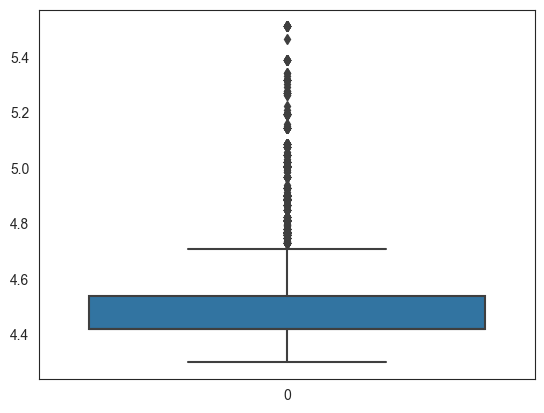

In [70]:
sns.boxplot(pd.DataFrame(outcomes).loc[:,'Min Water Level'])

Interpretation: 
1. The selected policies are stable in terms of minimum water level, as this parameter is always met. 
2. The EAD must be stabilized to remove outliers 

In [74]:
y= outcomes['Expected Annual Damage']>np.percentile(outcomes['Expected Annual Damage'],90)


array([False, False, False, ..., False, False, False])

Before analysing point 2 further, the next step considers robustness:

## 3.4 Robustness Analysis
This section performs a robustness analysis on the identified policies to further identify ideal solutions

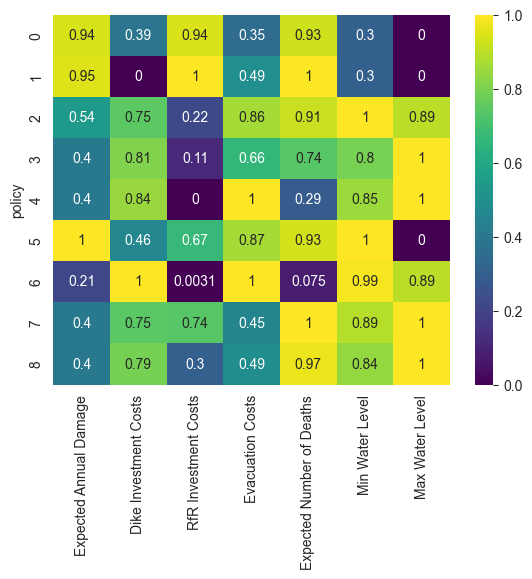

In [75]:
def calculate_regret(data, best):
    return np.abs(best-data)

overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()


Interpretation: As min water level is fulfilled (as observed earlier), the focus is on the EAD outcome. 
From this visualization, it can be concluded that: 
1. Policies 0,1 and 5 show high relative regret values and should be neglected.
2. Low EAD comes with high regret in cost. Policies 2, 3, 4, 6, 7 & 8 have acceptable regret values for EAD. This is true especially for policy 6

## 3.5 Scenario Discovery
In this section, a scenario discovery analysis is performed on the previously identified policies

In [25]:
archive_MORDM_2 = pd.read_excel('data_output/MORDM/archive_MORDM_2.xlsx')

In [31]:
policies_pareto_unc = archive_MORDM_2[archive_MORDM_2['Expected Annual Damage']==0].drop([o.name for o in dike_model.outcomes], axis=1)

#policies_pareto_unc.index = [i for i in range(9)]

policies_to_evaluate = []

for i, policy in policies_pareto_unc.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

print(policies_to_evaluate)


[Policy({'Unnamed: 0': 182, '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 3, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 3, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 3, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 7, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 4, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}), Policy({'Unnamed: 0': 209, '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 3, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 7, 'A

In [32]:
n_scenarios = 1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_mordm_2 = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

experiments_mordm_2, outcomes_mordm_2 = results_mordm_2



100%|██████████████████████████████████████| 9000/9000 [51:01<00:00,  2.94it/s]


In [34]:
pd.DataFrame(experiments_mordm_2).to_excel('experiments_MORDM_2.xlsx')
pd.DataFrame(outcomes_mordm_2).to_excel('outcomes_MORDM_2.xlsx')

<Axes: >

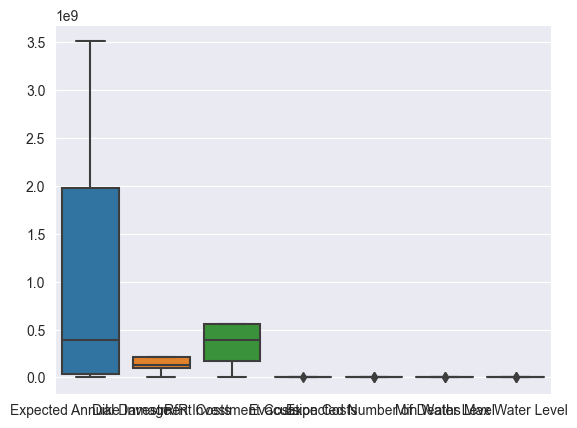

In [38]:
import seaborn as sns
sns.boxplot(pd.DataFrame(outcomes_mordm_2).describe([.25,.5, .75,.9,.95,.99]))

In [68]:
cleaned_experiments = pd.DataFrame(experiments_mordm_2).drop(labels=[l.name for l in dike_model.levers], axis=1)#.drop(labels=['policy','model','scenario'],axis=1)

data = pd.DataFrame(outcomes_mordm_2)['Expected Annual Damage']

y = data > np.percentile(data, 75)



0       False
1       False
2       False
3        True
4       False
        ...  
8995     True
8996     True
8997     True
8998    False
8999    False
Name: Expected Annual Damage, Length: 9000, dtype: bool


In [42]:
from ema_workbench.analysis import prim


prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8)


box1 = prim_alg.find_box()


NameError: name 'plt' is not defined

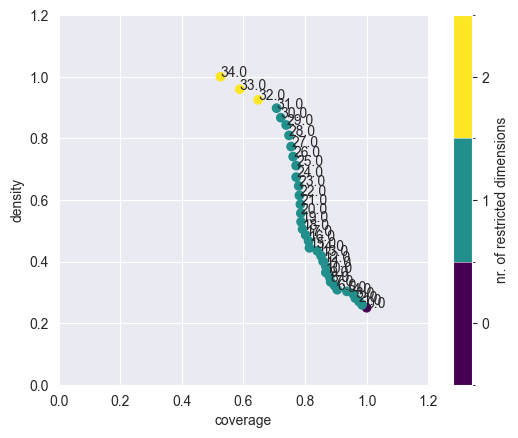

In [43]:
box1.show_tradeoff(annotated=True)
plt.show()

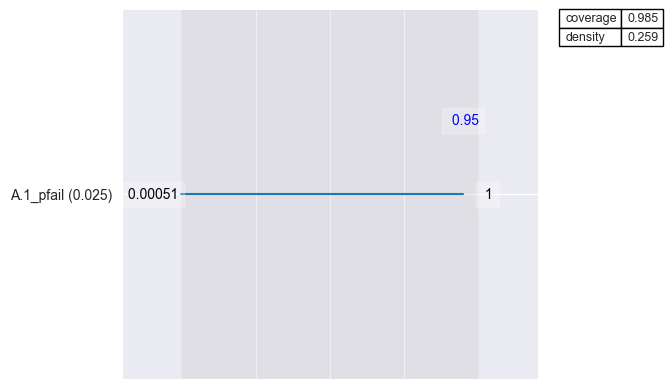

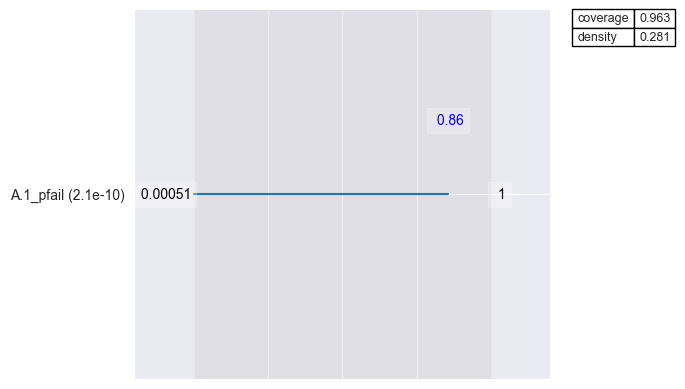

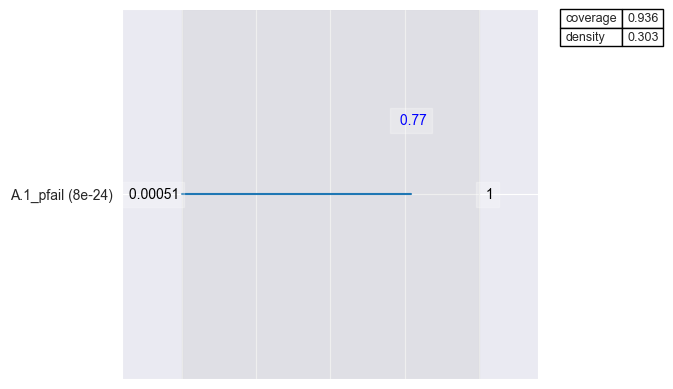

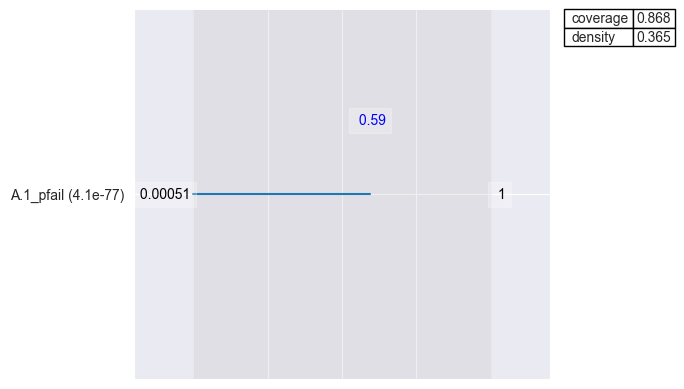

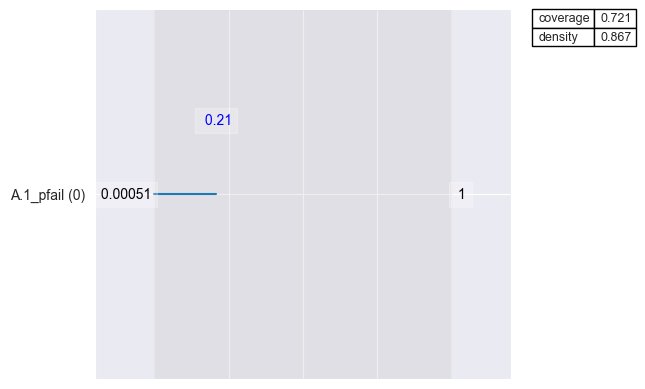

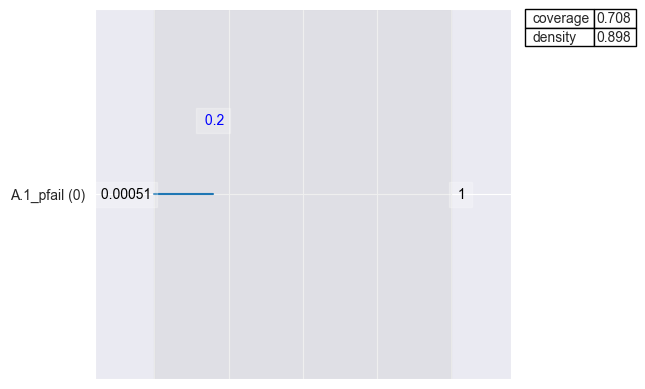

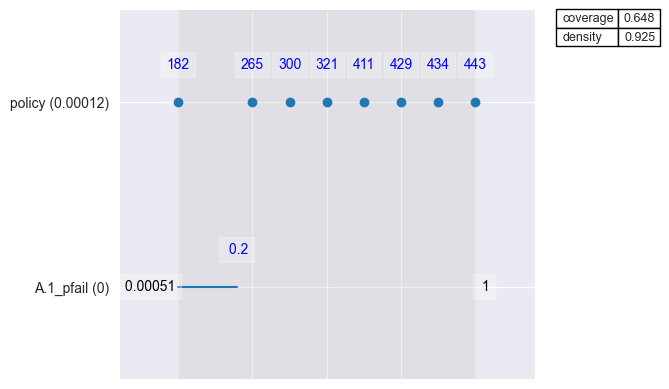

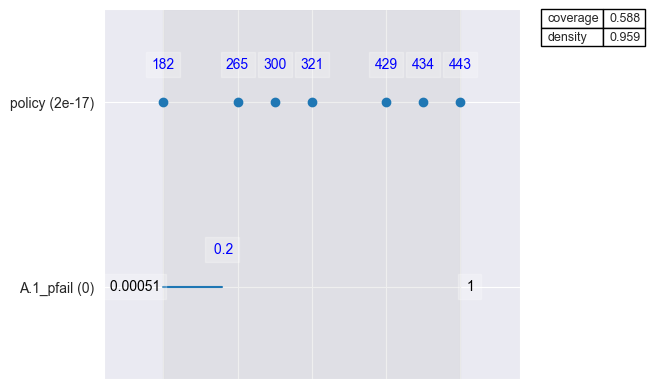

In [54]:
points = [1,3,5,10,30,31,32,33]
for point in points:
    box1.inspect(point,style='graph')

In [91]:
y_1 = {}

y_1['Expected Annual Damage']=outcomes_mordm_2['Expected Annual Damage'] > np.percentile(data,90)


{'Expected Annual Damage': array([False, False, False, ..., False, False, False])}

Interpretation: Low failure rates in location 1 lead to high expected annual damages. This is contradicts the understanding of the system, where it is expected that EAD should increase if the probability of dike failure increases.

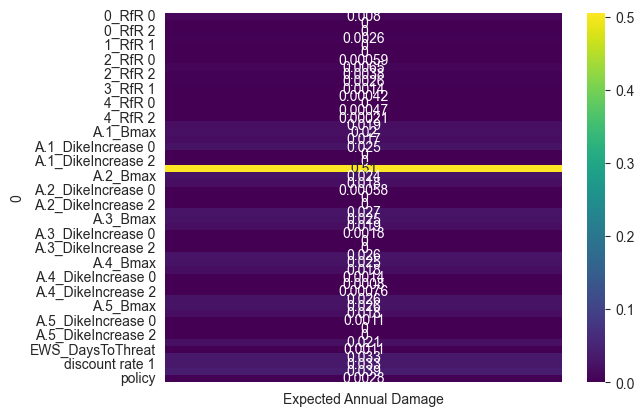

In [88]:
from ema_workbench.analysis import feature_scoring

import matplotlib.pyplot as plt

x = pd.DataFrame(experiments_mordm_2)


fs = feature_scoring.get_feature_scores_all(x, y_1)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [92]:
from ema_workbench.analysis import RuleInductionType



fs_1, alg = feature_scoring.get_ex_feature_scores(x, y_1['Expected Annual Damage'], mode=RuleInductionType.CLASSIFICATION)
fs_1.sort_values(ascending=False, by=1)

,1
0,
A.1_pfail,0.515964
discount rate 2,0.036543
discount rate 0,0.036398
discount rate 1,0.034409
A.3_pfail,0.026597
A.2_pfail,0.025676
A.1_DikeIncrease 0,0.025400
A.3_Bmax,0.024597
A.4_Bmax,0.023961


Interpretation: A.1_pfail has the highest impact on EAD. We assume that our findings are valid, therefore, the objective is to shrink pfail A1 to an interval of [.0005,.2]